In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap  # Assicurati di aver fatto: pip install umap-learn
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

class MultiStackPatchDataset(Dataset):
    def __init__(self, stack_paths, patch_size=64, num_patches=5000, use_layer='mean'):
        # stack_paths è una lista di percorsi, es: ["stacks/stack1.tif", "stacks/stack2.tif"]
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        self.imgs = []
        for sp in stack_paths:
            stack = tifffile.imread(sp)
            num_layers, H, W = stack.shape
            if use_layer == 'mean':
                img = stack.mean(axis=0).astype(np.float32)
            elif use_layer == 'middle':
                l = num_layers // 2
                img = stack[l].astype(np.float32)
            else:
                l = int(use_layer)
                img = stack[l].astype(np.float32)

            max_val = img.max() if img.max()>0 else 1.0
            img /= max_val
            self.imgs.append(img)
        
        # Dividiamo i patch tra le immagini
        patches_per_image = self.num_patches // len(self.imgs)
        
        self.coords = []
        self.img_indices = []
        
        for img_idx, img in enumerate(self.imgs):
            H, W = img.shape
            for _ in range(patches_per_image):
                y = np.random.randint(0, H - patch_size)
                x = np.random.randint(0, W - patch_size)
                self.coords.append((y,x))
                self.img_indices.append(img_idx)

        # Se num_patches non è divisibile esattamente, aggiungiamo i patch mancanti
        while len(self.coords) < self.num_patches:
            img_idx = np.random.randint(0, len(self.imgs))
            img = self.imgs[img_idx]
            H, W = img.shape
            y = np.random.randint(0, H - patch_size)
            x = np.random.randint(0, W - patch_size)
            self.coords.append((y,x))
            self.img_indices.append(img_idx)

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        img_idx = self.img_indices[idx]
        img = self.imgs[img_idx]
        y,x = self.coords[idx]
        patch = img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x), img_idx

class SmallEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super(SmallEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        # Normalizzazione
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

# Ora utilizziamo entrambe le immagini
stack_paths = ["stacks/stack1.tif", "stacks/stack2.tif"]
patch_size = 64
num_patches = 50000

dataset = MultiStackPatchDataset(stack_paths, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

encoder = SmallEncoder(out_dim=128)
model = SimCLR(encoder).to(device)
model.load_state_dict(torch.load(f"Combined_best_model_SimCLR_{patch_size}.pth"))

optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 1000
loss_history = []

# Parametri Early Stopping
best_loss = float('inf')
patience = 101  
no_improvement_count = 0

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for (view1, view2, _, _) in dataloader:
        view1 = view1.to(device)
        view2 = view2.to(device)
        optimizer.zero_grad()
        loss = model(view1, view2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss/len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")
    
    if epoch_loss < best_loss and epoch_loss < 0.1238:
        best_loss = epoch_loss
        no_improvement_count = 0
        print('Model Saved')
        torch.save(model.state_dict(), f"Combined_best_model_SimCLR_{patch_size}.pth")
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered!")
            break

plt.figure()
plt.plot(loss_history)
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_plot.png", dpi=300)
plt.close()


Using device: mps


/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_12828/3720776780.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"Combined

Epoch [1/1000] Loss: 0.1291
Epoch [2/1000] Loss: 0.1265
Epoch [3/1000] Loss: 0.1271
Epoch [4/1000] Loss: 0.1266
Epoch [5/1000] Loss: 0.1256
Epoch [6/1000] Loss: 0.1272
Epoch [7/1000] Loss: 0.1288
Epoch [8/1000] Loss: 0.1289
Epoch [9/1000] Loss: 0.1285
Epoch [10/1000] Loss: 0.1291
Epoch [11/1000] Loss: 0.1262
Epoch [12/1000] Loss: 0.1302
Epoch [13/1000] Loss: 0.1281
Epoch [14/1000] Loss: 0.1265
Epoch [15/1000] Loss: 0.1269
Epoch [16/1000] Loss: 0.1285
Epoch [17/1000] Loss: 0.1248
Epoch [18/1000] Loss: 0.1284
Epoch [19/1000] Loss: 0.1273
Epoch [20/1000] Loss: 0.1283
Epoch [21/1000] Loss: 0.1284
Epoch [22/1000] Loss: 0.1258
Epoch [23/1000] Loss: 0.1269
Epoch [24/1000] Loss: 0.1253
Epoch [25/1000] Loss: 0.1274
Epoch [26/1000] Loss: 0.1258
Epoch [27/1000] Loss: 0.1277
Epoch [28/1000] Loss: 0.1281
Epoch [29/1000] Loss: 0.1263
Epoch [30/1000] Loss: 0.1276
Epoch [31/1000] Loss: 0.1293
Epoch [32/1000] Loss: 0.1293
Epoch [33/1000] Loss: 0.1271
Epoch [34/1000] Loss: 0.1275
Epoch [35/1000] Loss: 0

Using device: mps


/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_14392/3775326737.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"Combined

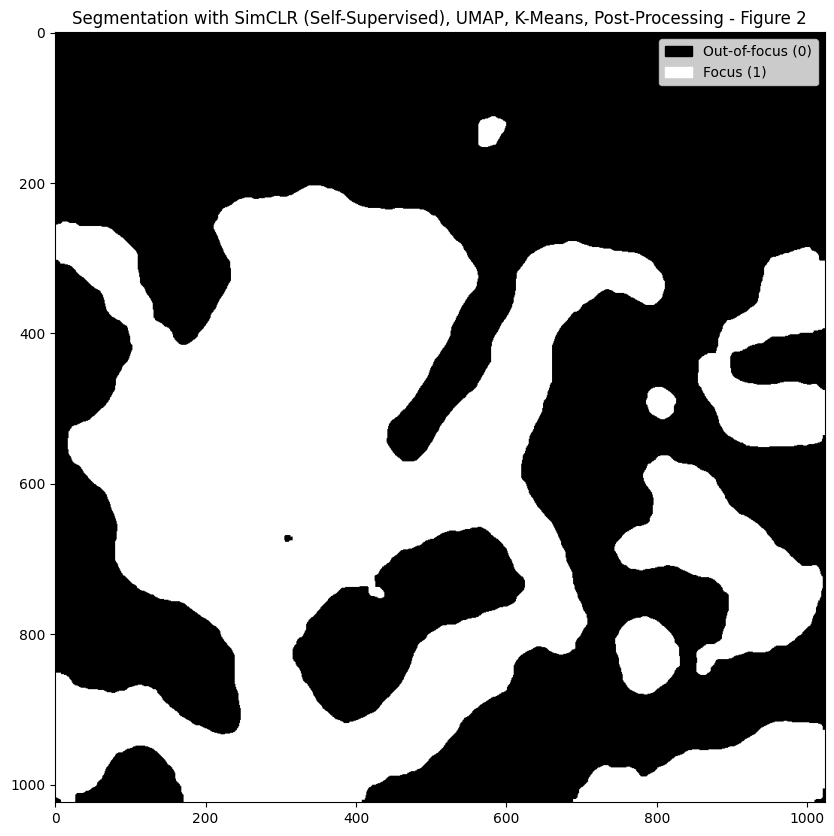

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as mpatches

class Patch2DDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, num_patches=5000, use_layer='mean'):
        self.stack = tifffile.imread(stack_path) # (num_layers,H,W)
        self.num_layers, self.H, self.W = self.stack.shape
        
        if use_layer == 'mean':
            self.img = self.stack.mean(axis=0).astype(np.float32)
        elif use_layer == 'middle':
            l = self.num_layers // 2
            self.img = self.stack[l].astype(np.float32)
        else:
            l = int(use_layer)
            self.img = self.stack[l].astype(np.float32)
        
        max_val = self.img.max() if self.img.max()>0 else 1.0
        self.img /= max_val
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((y,x))
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x)

class SmallEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super(SmallEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

# Visualizziamo i risultati su stack1 ad esempio
stack_path = "stacks/stack2.tif"
patch_size = 64
num_patches = 50000

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

encoder = SmallEncoder(out_dim=128)
model = SimCLR(encoder).to(device)

# Carichiamo il modello addestrato su entrambi gli stack
# (Assumendo che hai salvato il modello addestrato su stack1 e stack2 con lo stesso nome)
model.load_state_dict(torch.load(f"Combined_best_model_SimCLR_{patch_size}.pth"))
model.eval()

# Ora creiamo un dataset di visualizzazione solo per stack1
dataset_for_cluster = Patch2DDataset(stack_path, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader_for_cluster = DataLoader(dataset_for_cluster, batch_size=64, shuffle=False)

features = []
coords = dataset_for_cluster.coords
with torch.no_grad():
    for (view1, view2, c) in dataloader_for_cluster:
        view1 = view1.to(device)
        z = model.encoder(view1)
        z = z.cpu().numpy()
        features.append(z)
features = np.concatenate(features, axis=0)

reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = reducer.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(umap_features)

H, W = dataset_for_cluster.H, dataset_for_cluster.W
prob_map = np.zeros((H,W), dtype=np.float32)
count_map = np.zeros((H,W), dtype=np.float32)

for i, (y,x) in enumerate(coords):
    val = float(labels[i])
    prob_map[y:y+patch_size, x:x+patch_size] += val
    count_map[y:y+patch_size, x:x+patch_size] += 1.0

mask = np.zeros((H,W), dtype=np.float32)
valid = (count_map>0)
mask[valid] = prob_map[valid]/count_map[valid]
binary_map = (mask>0.5).astype(np.uint8)

binary_map = median_filter(binary_map, size=5)
binary_map = opening(binary_map, square(5))
binary_map = closing(binary_map, square(5))

plt.figure(figsize=(10,10))
plt.imshow(binary_map, cmap='gray')
plt.title("Segmentation with SimCLR (Self-Supervised), UMAP, K-Means, Post-Processing - Figure 2")

non_a_fuoco_patch = mpatches.Patch(color='black', label='Out-of-focus (0)')
a_fuoco_patch = mpatches.Patch(color='white', label='Focus (1)')

plt.legend(handles=[non_a_fuoco_patch, a_fuoco_patch], loc='upper right')
plt.show()
